In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

from circuit_specific.drawing_helpers import *
from general_qec.qec_helpers import *
from general_qec.gates import *
from general_qec.errors import *

# 3 qubit logical T1 calculation

## In this file we will restrict our 3 qubit connectivity to line connected circuit and implement our T1 and T2 error model to check for our logical T1 and T2 after running our 3 qubit correction circuit many times.

Recall the circuit for the 3 qubit error correction below

In [3]:
draw_three_qubit_code()

                                    ░                            ░ 
                    |ψ⟩: ──■────────░───■─────────■──────────────░─
                         ┌─┴─┐      ░   │         │              ░ 
                  |0⟩_0: ┤ X ├──■───░───┼────■────┼──────────────░─
                         └───┘┌─┴─┐ ░   │    │    │              ░ 
                  |0⟩_1: ─────┤ X ├─░───┼────┼────┼────■─────────░─
                              └───┘ ░ ┌─┴─┐┌─┴─┐  │    │  ┌─┐    ░ 
         syndrome |0⟩_0: ─────────────┤ X ├┤ X ├──┼────┼──┤M├────░─
                                      └───┘└───┘┌─┴─┐┌─┴─┐└╥┘┌─┐ ░ 
         syndrome |0⟩_1: ───────────────────────┤ X ├┤ X ├─╫─┤M├─░─
                                                └───┘└───┘ ║ └╥┘ ░ 
classical_measurement: 2/══════════════════════════════════╩══╩════
                                                           0  1    
+-----------------+---------------------------------+
|  Error Location |   Final State, |data⟩|ancilla⟩  |
+-------

Since we implemented our 3 qubit code using functions, we will need to pull those in here but change them up a bit.

In [4]:
zero = np.array([1, 0])
one = np.array([0, 1])

initial_psi = one # initialize our psi
initial_ancilla_state = np.array([1,0]) # initializing the |0> state of the qubits

# the parameters of our system
t1 = 200 * 10**-6
t2 = 150 * 10**-6
tg = 20 * 10**-9

# Initialize the 3 qubit logical state
initial_logical_state = np.kron(initial_psi, np.kron(initial_ancilla_state, np.kron(
    initial_ancilla_state, np.kron(initial_ancilla_state, initial_ancilla_state))))

# Find the density matrix of our logical system
initial_rho = np.kron(initial_logical_state, initial_logical_state[np.newaxis].conj().T)


# Apply the CNOT gates to the kronecker product of the current 3 qubit density matrix (the gates will implement t1 and t2)
final_rho = line_rad_CNOT(initial_rho, 0, 1, t1, t2, tg, form = 'rho') # first CNOT gate
final_rho = line_rad_CNOT(final_rho, 1, 2, t1, t2, tg, form = 'rho') # second CNOT gate

# probability of the state measurments from the density matrix are defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(final_rho)):
    prob_sum += np.abs(final_rho[i,i])
    state_probs = np.append(state_probs, final_rho[i,i])
    
print_state_info(state_probs, 5)

11100 :  0.9988340150115762


In [5]:
# apply a random x error using the density matrix

# Choose the index of the qubit you want to apply the error to.
error_index = random.randint(-1,2)
# Apply the error to the qubit (no error may occur)
if error_index == 0:
    gate = np.kron(sigma_x, np.identity(2**4))
    errored_rho = np.dot(gate, np.dot(final_rho, gate.conj().T))
                   
elif error_index == 1:
    gate = np.kron(np.kron(np.identity(2), sigma_x), np.identity(2**3))
    errored_rho = np.dot(gate, np.dot(final_rho, gate.conj().T))
                   
elif error_index == 2:
    gate = np.kron(np.identity(2**2), np.kron(sigma_x, np.identity(2**2)))
    errored_rho = np.dot(gate, np.dot(final_rho, gate.conj().T))

else:
    errored_rho = final_rho

                   
# probability of the state measurments from the density matrix are defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(errored_rho)):
    prob_sum += np.abs(errored_rho[i,i])
    state_probs = np.append(state_probs, errored_rho[i,i])
    
print_state_info(state_probs, 5)

01100 :  0.9988340150115762


Now to implement the CNOT gates to couple the syndrome ancilla with the logical qubit

In [6]:
# Apply the CNOT gates needed to change the state of the syndrome ancilla 
detection_rho = line_rad_CNOT(errored_rho, 0, 3, t1, t2, tg, form = 'rho')
detection_rho = line_rad_CNOT(detection_rho, 1, 3, t1, t2, tg, form = 'rho')
detection_rho = line_rad_CNOT(detection_rho, 0, 4, t1, t2, tg, form = 'rho')
detection_rho = line_rad_CNOT(detection_rho, 2, 4, t1, t2, tg, form = 'rho')

# probability of the state measurments from the density matrix are defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(detection_rho)):
    prob_sum += np.abs(detection_rho[i,i])
    state_probs = np.append(state_probs, detection_rho[i,i])
    
print_state_info(state_probs, 5)

01111 :  0.9826522561370129


Now detect where the error occured by measuring the two syndrom ancilla

In [7]:
logical_bits = vector_state_to_bit_state(state_probs, 5)[0][0]

# Initialize error index
error_index = -1

if ((logical_bits[3] == '1') and (logical_bits[4] == '1')): # Error on qubit 0
    error_index = 0
elif ((logical_bits[3] == '1') and (logical_bits[4] == '0')): # Error on qubit 1
    error_index = 1
elif ((logical_bits[3] == '0') and (logical_bits[4] == '1')): # Error on qubit 2
    error_index = 2
elif(logical_bits[3] and logical_bits[4] == '0'): # No error occured
    print("No bit flip error occured.")

print('Error occured on qubit: ', error_index)

Error occured on qubit:  0


Now to correct for our error

In [8]:
if error_index == 0: # Error on qubit 0
    correction_gate = np.kron(sigma_x, np.identity(2**4))
    corrected_rho = np.dot(correction_gate, np.dot(detection_rho, correction_gate.conj().T))
    
elif error_index == 1: # Error on qubit 1
    correction_gate = np.kron(np.identity(2), np.kron(sigma_x, np.identity(2**3)))
    corrected_rho = np.dot(correction_gate, np.dot(detection_rho, correction_gate.conj().T))

    
elif error_index == 2: # Error on qubit 2
    correction_gate = np.kron(np.identity(2**2), np.kron(sigma_x, np.identity(2**2)))
    corrected_rho = np.dot(correction_gate, np.dot(detection_rho, correction_gate.conj().T))
    
    
else: # No error occured
    corrected_rho = detection_rho
                           
# probability of the state measurments from the density matrix are defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(corrected_rho)):
    prob_sum += np.abs(corrected_rho[i,i])
    state_probs = np.append(state_probs, corrected_rho[i,i])
    
print_state_info(state_probs, 5)

11111 :  0.9826522561370129


In [9]:
reset_state = ancilla_reset(state_probs, 2)
print_state_info(reset_state, 5)

11100 :  0.9826522561370129


Now to calculate the logical T1 for the 3 qubit bit correction circuit

In [10]:
def three_qubit_logical_t1_test(initial_rho, t1, t2, tg):
    # apply a random x error using the density matrix
    
    # Choose the index of the qubit you want to apply the error to.
    error_index = random.randint(-1,2)
    # Apply the error to the qubit (no error may occur)
    if error_index == 0:
        gate = np.kron(sigma_x, np.identity(2**4))
        errored_rho = np.dot(gate, np.dot(initial_rho, gate.conj().T))

    elif error_index == 1:
        gate = np.kron(np.kron(np.identity(2), sigma_x), np.identity(2**3))
        errored_rho = np.dot(gate, np.dot(initial_rho, gate.conj().T))

    elif error_index == 2:
        gate = np.kron(np.identity(2**2), np.kron(sigma_x, np.identity(2**2)))
        errored_rho = np.dot(gate, np.dot(initial_rho, gate.conj().T))

    else:
        errored_rho = initial_rho


    # probability of the state measurments from the density matrix are defined as Tr(p*rho)
    prob_sum = 0
    state_probs = np.array([])
    for i in range(len(errored_rho)):
        prob_sum += np.abs(errored_rho[i,i])
        state_probs = np.append(state_probs, errored_rho[i,i])

    # Apply the CNOT gates needed to change the state of the syndrome ancilla 
    detection_rho = line_rad_CNOT(errored_rho, 0, 3, t1, t2, tg, form = 'rho')
    detection_rho = line_rad_CNOT(detection_rho, 1, 3, t1, t2, tg, form = 'rho')
    detection_rho = line_rad_CNOT(detection_rho, 0, 4, t1, t2, tg, form = 'rho')
    detection_rho = line_rad_CNOT(detection_rho, 2, 4, t1, t2, tg, form = 'rho')

    # probability of the state measurments from the density matrix are defined as Tr(p*rho)
    prob_sum = 0
    state_probs = np.array([])
    for i in range(len(detection_rho)):
        prob_sum += np.abs(detection_rho[i,i])
        state_probs = np.append(state_probs, detection_rho[i,i])

    logical_bits = vector_state_to_bit_state(state_probs, 5)[0][0]

    # Initialize error index
    error_index = -1

    if ((logical_bits[3] == '1') and (logical_bits[4] == '1')): # Error on qubit 0
        error_index = 0
    elif ((logical_bits[3] == '1') and (logical_bits[4] == '0')): # Error on qubit 1
        error_index = 1
    elif ((logical_bits[3] == '0') and (logical_bits[4] == '1')): # Error on qubit 2
        error_index = 2


    if error_index == 0: # Error on qubit 0
        correction_gate = np.kron(sigma_x, np.identity(2**4))
        corrected_rho = np.dot(correction_gate, np.dot(detection_rho, correction_gate.conj().T))
        corrected_rho = qubit_rad_error_matrix(corrected_rho, t1, t2, tg) # apply rad error

    elif error_index == 1: # Error on qubit 1
        correction_gate = np.kron(np.identity(2), np.kron(sigma_x, np.identity(2**3)))
        corrected_rho = np.dot(correction_gate, np.dot(detection_rho, correction_gate.conj().T))
        corrected_rho = qubit_rad_error_matrix(corrected_rho, t1, t2, tg) # apply rad error


    elif error_index == 2: # Error on qubit 2
        correction_gate = np.kron(np.identity(2**2), np.kron(sigma_x, np.identity(2**2)))
        corrected_rho = np.dot(correction_gate, np.dot(detection_rho, correction_gate.conj().T))
        corrected_rho = qubit_rad_error_matrix(corrected_rho, t1, t2, tg) # apply rad error


    else: # No error occured
        corrected_rho = detection_rho
        corrected_rho = qubit_rad_error_matrix(corrected_rho, t1, t2, tg) # apply rad error

    # probability of the state measurments from the density matrix are defined as Tr(p*rho)
    prob_sum = 0
    state_probs = np.array([])
    for i in range(len(corrected_rho)):
        prob_sum += np.abs(corrected_rho[i,i])
        state_probs = np.append(state_probs, corrected_rho[i,i])

    # reset ancilla qubits (since we have a probability of being in a state we squareroot it to find the magnitude)
    reset_state = np.sqrt(ancilla_reset(state_probs, 2))

    # now we find the density matrix of our state 
    reset_rho = np.kron(reset_state, reset_state[np.newaxis].conj().T)
    
    return reset_rho, prob_sum

In [11]:
zero = np.array([1, 0])
one = np.array([0, 1])

initial_psi = one # initialize our psi
initial_ancilla_state = np.array([1,0]) # initializing the |0> state of the qubits

# the parameters of our system
t1 = 200 * 10**-6 # 200 us
t2 = 150 * 10**-6 # 150 us
tg = 20 * 10**-9 # 20 ns

# Initialize the 3 qubit logical state
initial_logical_state = np.kron(initial_psi, np.kron(initial_ancilla_state, np.kron(
    initial_ancilla_state, np.kron(initial_ancilla_state, initial_ancilla_state))))

# Find the density matrix of our logical system
rho = np.kron(initial_logical_state, initial_logical_state[np.newaxis].conj().T)


# Apply the CNOT gates to the kronecker product of the current 3 qubit density matrix (the gates will implement t1 and t2)
initial_rho = line_rad_CNOT(rho, 0, 1, t1, t2, tg, form = 'rho') # first CNOT gate
initial_rho = line_rad_CNOT(initial_rho, 1, 2, t1, t2, tg, form = 'rho') # second CNOT gate

all_probs = np.array([])
count = np.array([])
# Apply the function above 100 times to run the circuit 100 times
for i in range(200):
    count = np.append(count, i)
    if i == 0:
        reset_rho, prob_sum = three_qubit_logical_t1_test(initial_rho, t1, t2, tg)
    else:
        reset_rho, prob_sum = three_qubit_logical_t1_test(reset_rho, t1, t2, tg)
    
    all_probs = np.append(all_probs, prob_sum)
    

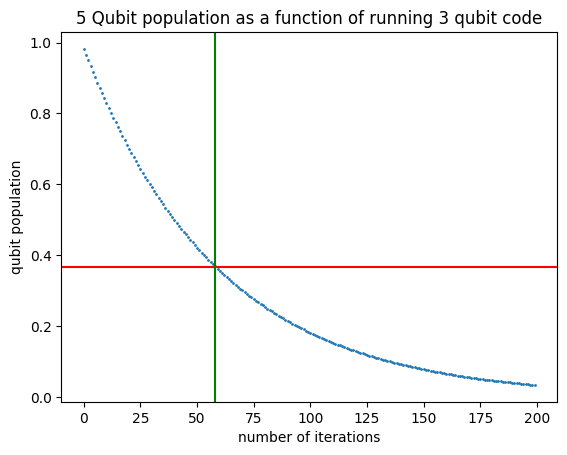

In [12]:
plt.scatter(count, all_probs, s = 1)
plt.title('5 Qubit population as a function of running 3 qubit code')
plt.xlabel('number of iterations')
plt.ylabel('qubit population')
plt.axhline(y = 1/np.e, color = 'r', linestyle = '-')
plt.axvline(x = 58, color = 'g', linestyle = '-')

plt.show()

58 iterations is where we have logical T1

each iteration is composed of 29 gates (including correction but not including initialization since that is not repeated)

In [13]:
n_gates = 58 * 29 + 2 # total number of gates until population reaches 1/e
tg # time per gate operation
print('The total number of gates are ', n_gates, ' with each gate taking ', tg, ' seconds')
print(' - - - - - ')

print('Each qubit has a physical T1 and T2 of ', t1, ' and ', t2, ' seconds respectivly')
print(' - - - - - ')

total_time = n_gates * tg # total time until logical T1
print('The total system has a Logical T1 of ', total_time, ' seconds')

The total number of gates are  1684  with each gate taking  2e-08  seconds
 - - - - - 
Each qubit has a physical T1 and T2 of  0.00019999999999999998  and  0.00015  seconds respectivly
 - - - - - 
The total system has a Logical T1 of  3.368e-05  seconds


Now to sweep over the T1 of our physical qubits and see how that effects the logical T1 of our system

In [15]:
initial_psi = one # initialize our psi
initial_ancilla_state = np.array([1,0]) # initializing the |0> state of the qubits

# the parameters of our system
t1 = 100 * 10**-6 # 100 us - the initial T1
t2 = 100 * 10**-6 # 150 us - Make sure this is less than or equal to T1
tg = 20 * 10**-9 # 20 ns

# Initialize the 3 qubit logical state
initial_logical_state = np.kron(initial_psi, np.kron(initial_ancilla_state, np.kron(
    initial_ancilla_state, np.kron(initial_ancilla_state, initial_ancilla_state))))

# Find the density matrix of our logical system
rho = np.kron(initial_logical_state, initial_logical_state[np.newaxis].conj().T)
all_probs = np.array([[]])
all_counts = np.array([[]])
all_t1 = np.array([])
for j in range(200):
    
    all_t1 = np.append(all_t1, t1)
    
    # Apply the CNOT gates to the kronecker product of the current 3 qubit density matrix (the gates will implement t1 and t2)
    initial_rho = line_rad_CNOT(rho, 0, 1, t1, t2, tg, form = 'rho') # first CNOT gate
    initial_rho = line_rad_CNOT(initial_rho, 1, 2, t1, t2, tg, form = 'rho') # second CNOT gate

    probs = np.array([])
    count = np.array([])
    # Apply the function above 100 times to run the circuit 100 times
    for i in range(200):
        count = np.append(count, i)
        if i == 0:
            reset_rho, prob_sum = three_qubit_logical_t1_test(initial_rho, t1, t2, tg)
        else:
            reset_rho, prob_sum = three_qubit_logical_t1_test(reset_rho, t1, t2, tg)

        probs = np.append(probs, prob_sum)
    
    if j == 0:
        all_probs = [probs]
        all_counts = [count]
    else:
        all_probs = np.append(all_probs, [probs], axis = 0)
        all_counts = np.append(all_counts, [count], axis = 0)

    t1+= 5 * 10**-7 # add 0.5 us to T1


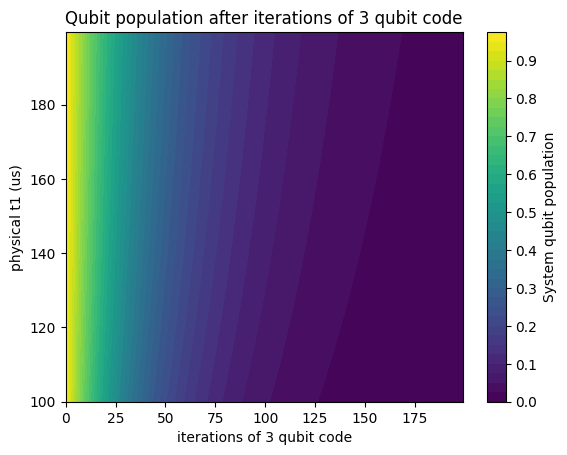

In [16]:
# Creating 2-D grid of features
[X, Y] = np.meshgrid(all_counts[0], all_t1)
  
fig, ax = plt.subplots(1, 1)
  
Z = all_probs
levels = np.arange(0, 1, 0.025)

cp = plt.contourf(X, Y * 10**6, Z, levels)
cbar = plt.colorbar()
ax.set_title('Qubit population after iterations of 3 qubit code')
ax.set_xlabel('iterations of 3 qubit code')
ax.set_ylabel('physical t1 (us)')
cbar.set_label('System qubit population')

plt.show()

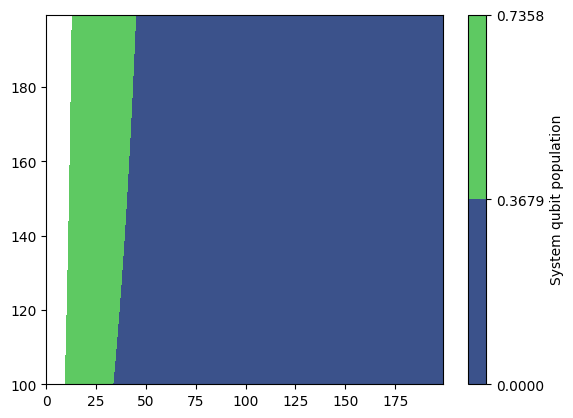

In [17]:
levels = np.arange(0, 1, 1/np.e)

cp = plt.contourf(X, Y * 10**6, Z, levels)
cbar = plt.colorbar()
ax.set_title('Qubit population after iterations of 3 qubit code')
ax.set_xlabel('iterations of 3 qubit code')
ax.set_ylabel('physical t1 (us)')
cbar.set_label('System qubit population')

plt.show()